# Visualização de Predições - Modelo Wavelet Skip 1

**Modelo:** UNet + EfficientNet-B4 + Wavelet DWT no primeiro skip  
**Performance:** Test Dice = 0.6721  
- Exsudatos: 0.7275  
- Hemorragias: 0.6167  

Este notebook visualiza predições do melhor modelo em amostras do test set.

In [5]:
import sys
sys.path.append('..')

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from configs.config import Config
from data_factory.data_factory import DataFactory
from data_factory.ROP_dataset import ROPDataset
from models.unet_wavelet_skip1 import UnetWaveletSkip1
from torch.utils.data import DataLoader

print('✓ Imports OK')

✓ Imports OK


## 1. Configuração e Carregamento do Modelo

In [6]:
# Config
config = Config()
config.img_size = 512
config.apply_clahe = False
config.batch_size = 1
config.encoder_name = 'efficientnet-b4'
config.num_classes = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

# Carregar test set
data_factory = DataFactory(config)
train_df, test_df = data_factory.create_metadata_dataframe()

print(f'Test images: {len(test_df)}')

Device: cuda
Creating metadata DataFrames...
Train set: 54 images
Test set: 27 images
Test images: 27


In [7]:
# Criar dataset
test_dataset = ROPDataset(
    dataframe=test_df,
    config=config,
    is_train=False
)

print(f'Dataset size: {len(test_dataset)}')

Dataset size: 27


In [10]:
# Carregar modelos ensemble (5 folds)
model_paths = [
    '../outputs/checkpoints/best_model_fold1.pth',
    '../outputs/checkpoints/best_model_fold2.pth',
    '../outputs/checkpoints/best_model_fold3.pth',
    '../outputs/checkpoints/best_model_fold4.pth',
    '../outputs/checkpoints/best_model_fold5.pth'
]

models = []
for i, path in enumerate(model_paths):
    model = UnetWaveletSkip1(
        encoder_name=config.encoder_name,
        encoder_weights=None,
        in_channels=3,
        classes=config.num_classes
    )
    
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint)
    model = model.to(device)
    model.eval()
    models.append(model)
    print(f'✓ Loaded model {i+1}/5')

print(f'\n✓ Ensemble de {len(models)} modelos carregado')

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL configs.config.Config was not an allowed global by default. Please use `torch.serialization.add_safe_globals([configs.config.Config])` or the `torch.serialization.safe_globals([configs.config.Config])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [12]:
# Limpar variáveis anteriores
if 'models' in globals():
    del models
if 'model' in globals():
    del model

# Carregar modelos ensemble (5 folds) - CORRIGIDO
model_paths = [
    '../outputs/checkpoints/best_model_fold1.pth',
    '../outputs/checkpoints/best_model_fold2.pth',
    '../outputs/checkpoints/best_model_fold3.pth',
    '../outputs/checkpoints/best_model_fold4.pth',
    '../outputs/checkpoints/best_model_fold5.pth'
]

models = []
for i, path in enumerate(model_paths):
    model = UnetWaveletSkip1(
        encoder_name=config.encoder_name,
        encoder_weights=None,
        in_channels=3,
        classes=config.num_classes
    )
    
    # Carregar checkpoint completo
    checkpoint = torch.load(path, map_location=device, weights_only=False)
    
    # Extrair apenas os pesos do modelo
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    models.append(model)
    print(f'✓ Loaded model {i+1}/5')

print(f'\n✓ Ensemble de {len(models)} modelos carregado')

✓ Loaded model 1/5
✓ Loaded model 2/5
✓ Loaded model 3/5
✓ Loaded model 4/5
✓ Loaded model 5/5

✓ Ensemble de 5 modelos carregado


## 2. Função de Predição com Ensemble

In [13]:
def predict_ensemble(image_tensor, models, device):
    """
    Predição usando ensemble de modelos.
    
    Args:
        image_tensor: [1, 3, 512, 512]
        models: lista de modelos
        device: cuda ou cpu
    
    Returns:
        pred_mask: [2, 512, 512] - probabilidades
    """
    image_tensor = image_tensor.to(device)
    
    all_preds = []
    
    with torch.no_grad():
        for model in models:
            output = model(image_tensor)  # [1, 2, 512, 512]
            prob = torch.sigmoid(output)  # [1, 2, 512, 512]
            all_preds.append(prob)
    
    # Média do ensemble
    ensemble_pred = torch.stack(all_preds).mean(dim=0)  # [1, 2, 512, 512]
    
    return ensemble_pred[0].cpu().numpy()  # [2, 512, 512]

print('✓ Função de predição definida')

✓ Função de predição definida


## 3. Função de Visualização

In [14]:
def visualize_prediction(idx, test_dataset, models, device, threshold=0.5):
    """
    Visualiza imagem original, ground truth e predição.
    
    Args:
        idx: índice da amostra no test_dataset
        test_dataset: dataset de teste
        models: lista de modelos
        device: cuda ou cpu
        threshold: limiar para binarização
    """
    # Carregar amostra
    sample = test_dataset[idx]
    image_tensor = sample['image'].unsqueeze(0)  # [1, 3, 512, 512]
    gt_mask = sample['mask'].numpy()  # [2, 512, 512]
    
    # Predição
    pred_mask = predict_ensemble(image_tensor, models, device)  # [2, 512, 512]
    
    # Desnormalizar imagem para visualização
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    image_np = image_tensor[0].cpu().numpy().transpose(1, 2, 0)  # [512, 512, 3]
    image_np = image_np * std + mean
    image_np = np.clip(image_np, 0, 1)
    
    # Binarizar predição
    pred_binary = (pred_mask > threshold).astype(np.uint8)
    
    # Plot
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # LINHA 1: EXSUDATOS
    axes[0, 0].imshow(image_np)
    axes[0, 0].set_title('Imagem Original', fontsize=14, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(gt_mask[0], cmap='gray')
    axes[0, 1].set_title('Ground Truth - Exsudatos', fontsize=14, fontweight='bold')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(pred_mask[0], cmap='hot', vmin=0, vmax=1)
    axes[0, 2].set_title('Predição (prob) - Exsudatos', fontsize=14, fontweight='bold')
    axes[0, 2].axis('off')
    
    axes[0, 3].imshow(pred_binary[0], cmap='gray')
    axes[0, 3].set_title(f'Predição (thresh={threshold}) - Exsudatos', fontsize=14, fontweight='bold')
    axes[0, 3].axis('off')
    
    # LINHA 2: HEMORRAGIAS
    axes[1, 0].imshow(image_np)
    axes[1, 0].set_title('Imagem Original', fontsize=14, fontweight='bold')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(gt_mask[1], cmap='gray')
    axes[1, 1].set_title('Ground Truth - Hemorragias', fontsize=14, fontweight='bold')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(pred_mask[1], cmap='hot', vmin=0, vmax=1)
    axes[1, 2].set_title('Predição (prob) - Hemorragias', fontsize=14, fontweight='bold')
    axes[1, 2].axis('off')
    
    axes[1, 3].imshow(pred_binary[1], cmap='gray')
    axes[1, 3].set_title(f'Predição (thresh={threshold}) - Hemorragias', fontsize=14, fontweight='bold')
    axes[1, 3].axis('off')
    
    # Calcular Dice
    def dice_score(pred, gt):
        intersection = (pred * gt).sum()
        return (2. * intersection) / (pred.sum() + gt.sum() + 1e-8)
    
    dice_exudatos = dice_score(pred_binary[0], gt_mask[0])
    dice_hemorragias = dice_score(pred_binary[1], gt_mask[1])
    dice_mean = (dice_exudatos + dice_hemorragias) / 2
    
    fig.suptitle(
        f'Amostra {idx+1} - Dice: {dice_mean:.4f} (Exsudatos: {dice_exudatos:.4f}, Hemorragias: {dice_hemorragias:.4f})',
        fontsize=16,
        fontweight='bold',
        y=0.98
    )
    
    plt.tight_layout()
    plt.show()
    
    return dice_exudatos, dice_hemorragias, dice_mean

print('✓ Função de visualização definida')

✓ Função de visualização definida


## 4. Visualizar Amostras do Test Set

Vamos visualizar algumas amostras representativas.

In [15]:
# Selecionar amostras aleatórias
import random
random.seed(42)

num_samples = 6
sample_indices = random.sample(range(len(test_dataset)), num_samples)

print(f'Visualizando {num_samples} amostras aleatórias do test set...')
print(f'Índices: {sample_indices}')

Visualizando 6 amostras aleatórias do test set...
Índices: [20, 3, 0, 23, 8, 7]



Processando amostra 21/27


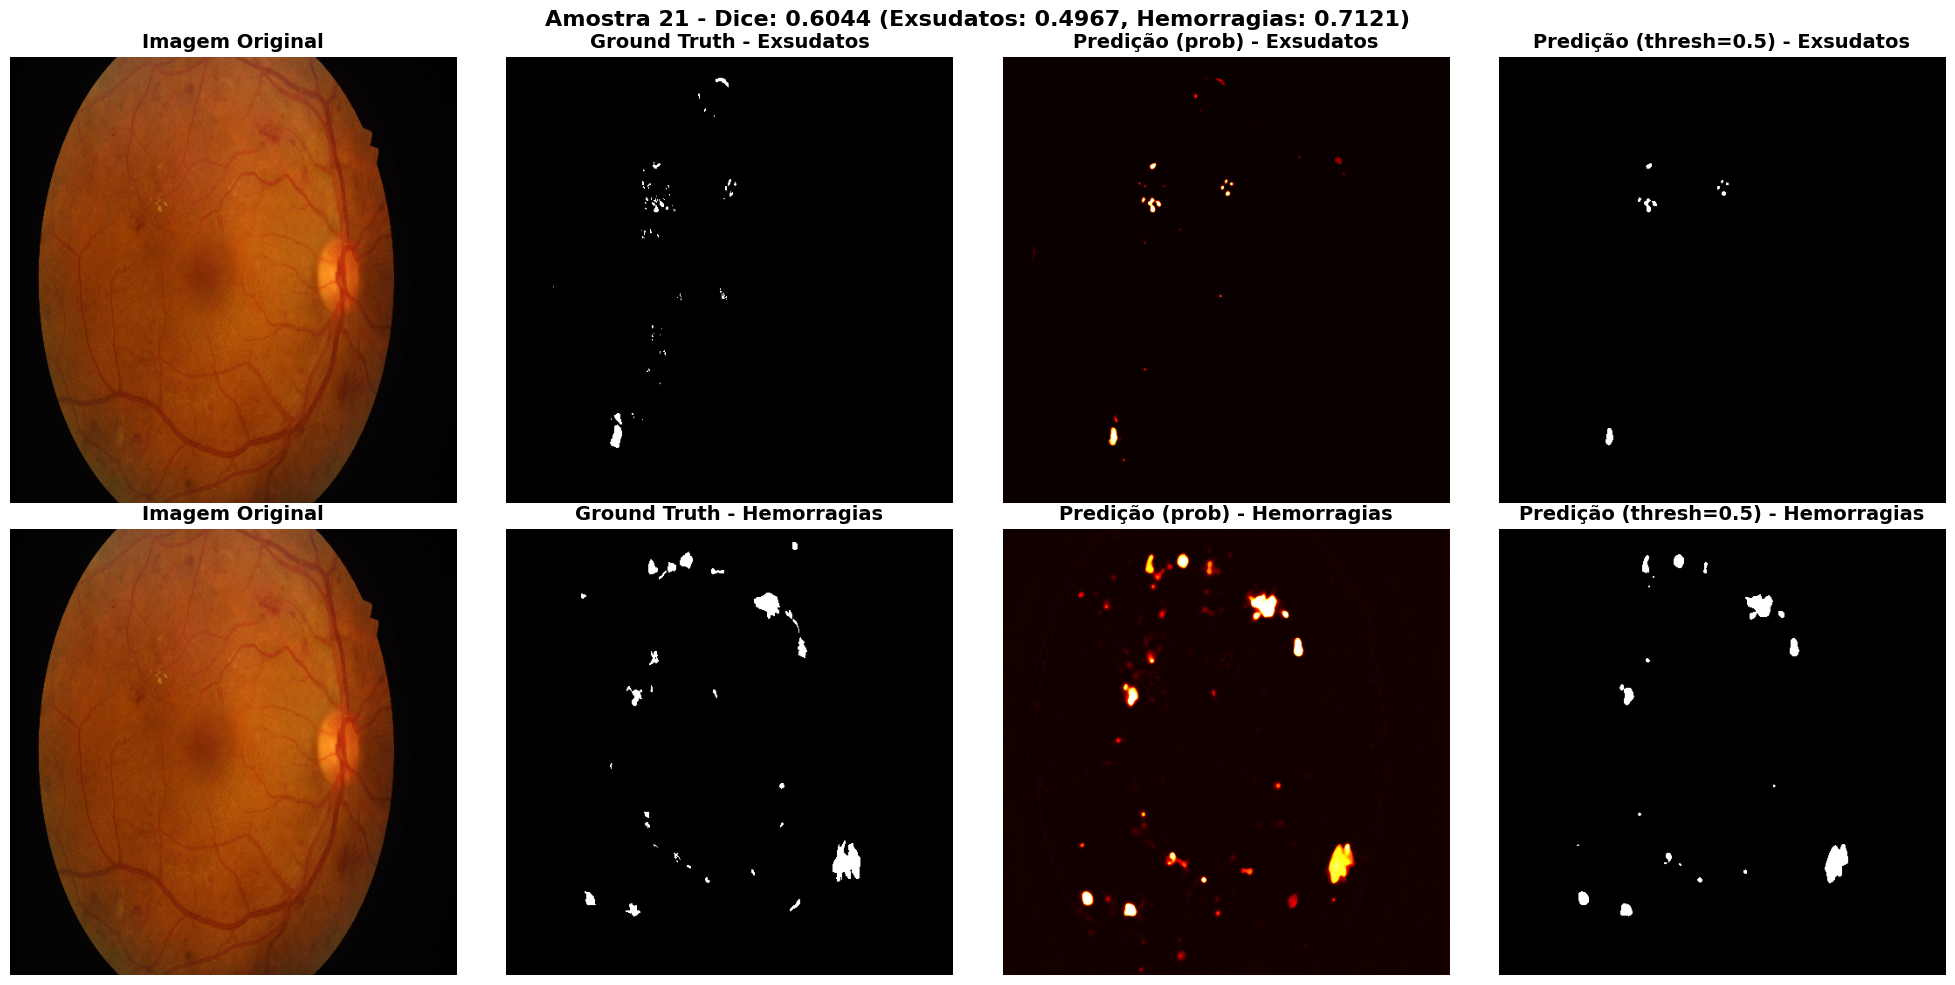

Dice Exsudatos: 0.4967
Dice Hemorragias: 0.7121
Dice Mean: 0.6044

Processando amostra 4/27


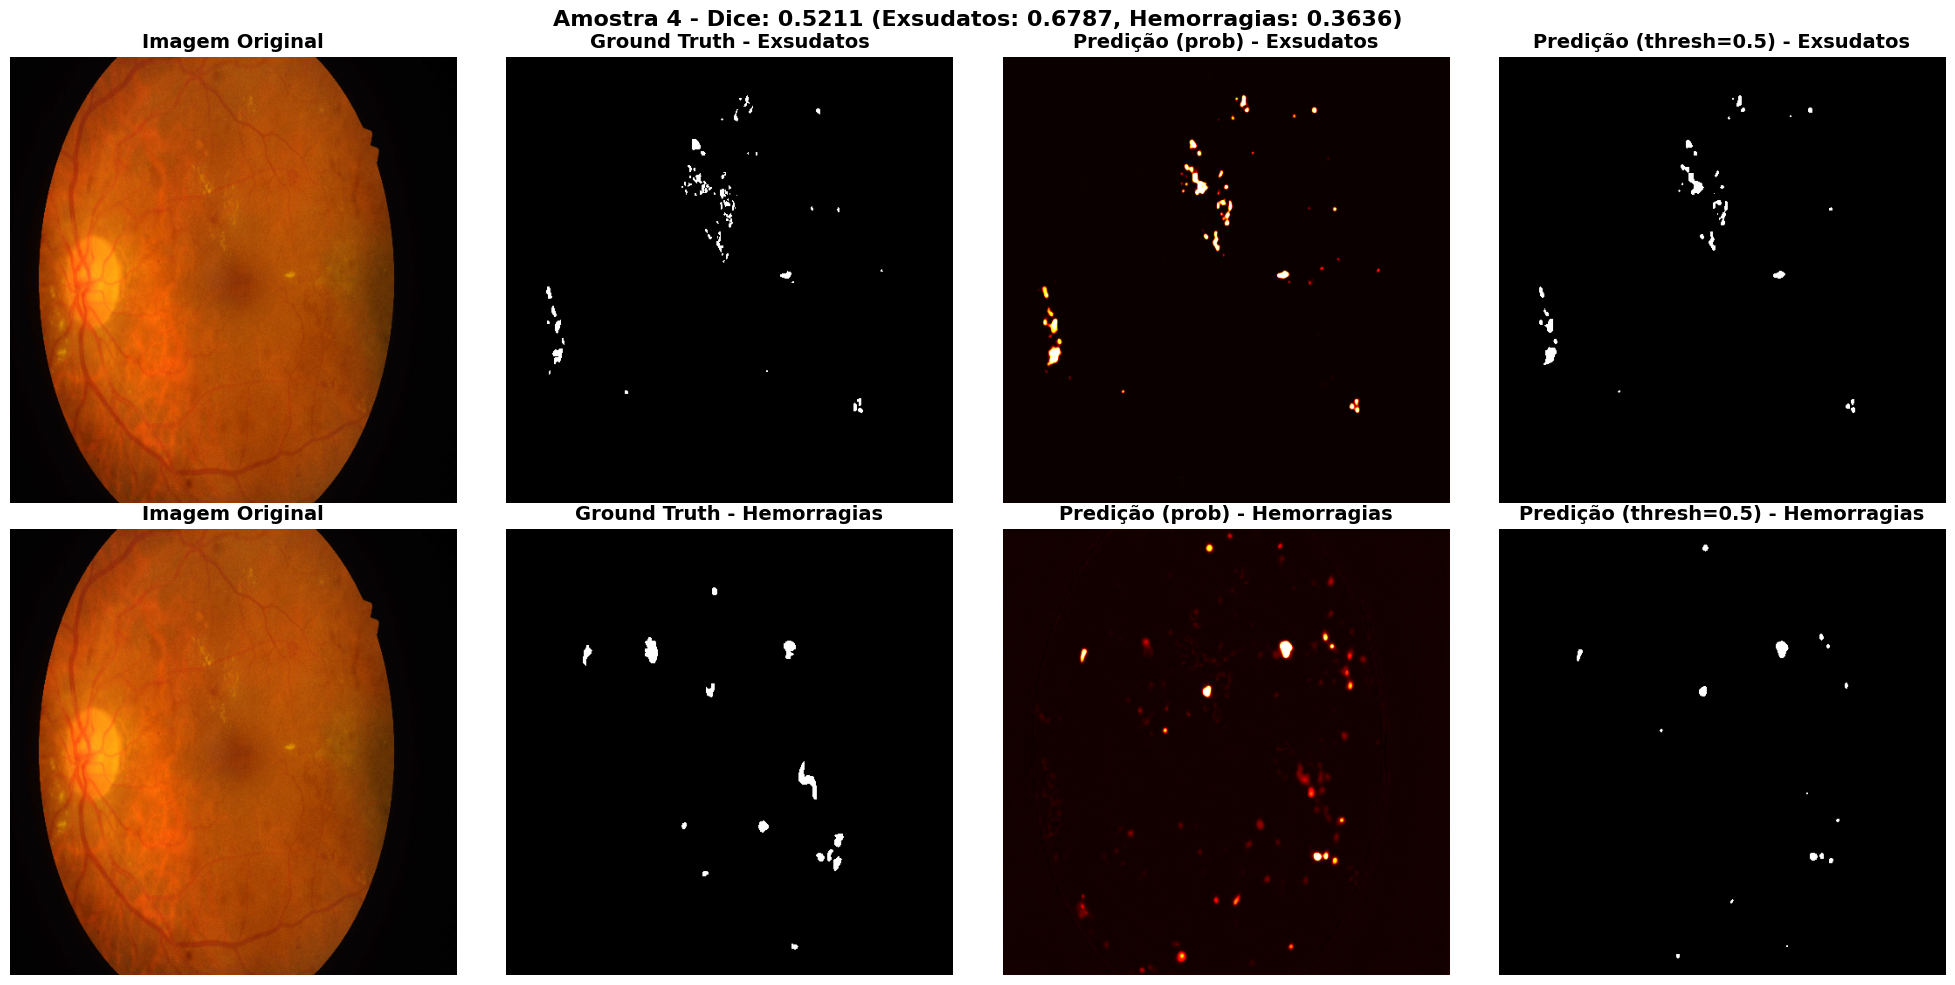

Dice Exsudatos: 0.6787
Dice Hemorragias: 0.3636
Dice Mean: 0.5211

Processando amostra 1/27


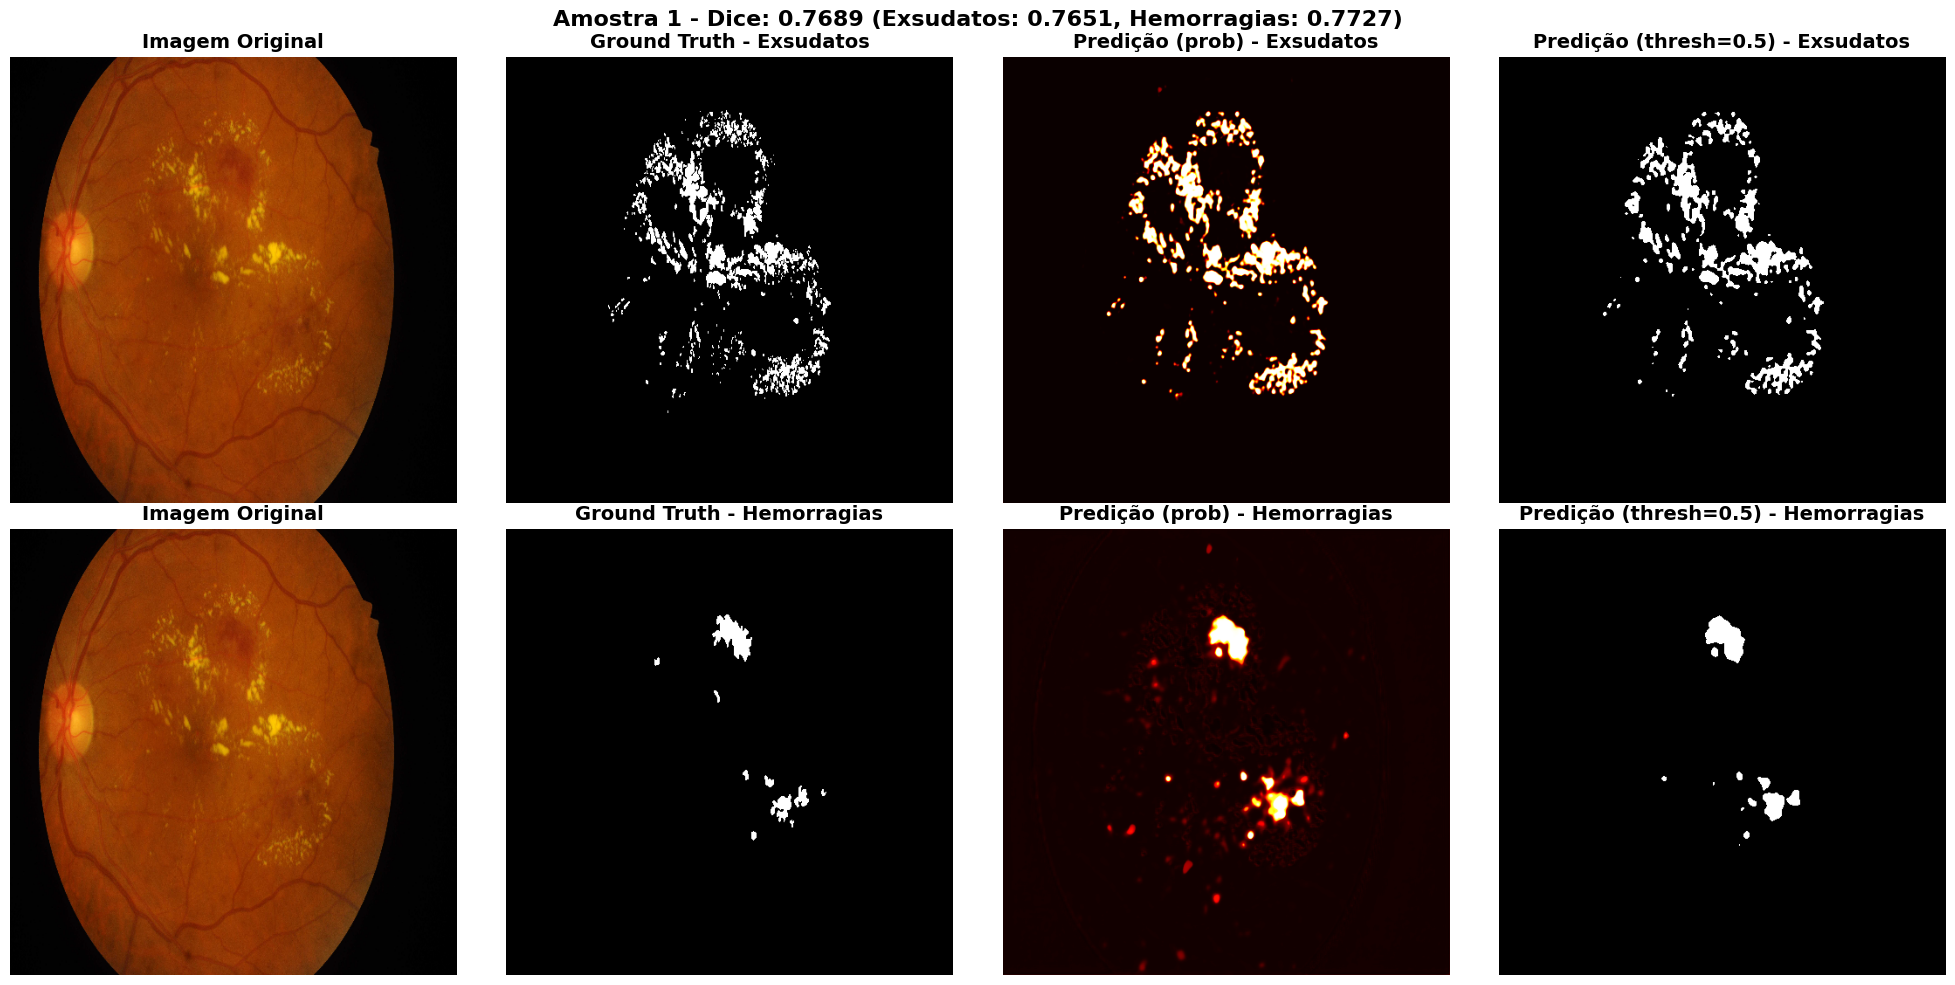

Dice Exsudatos: 0.7651
Dice Hemorragias: 0.7727
Dice Mean: 0.7689

Processando amostra 24/27


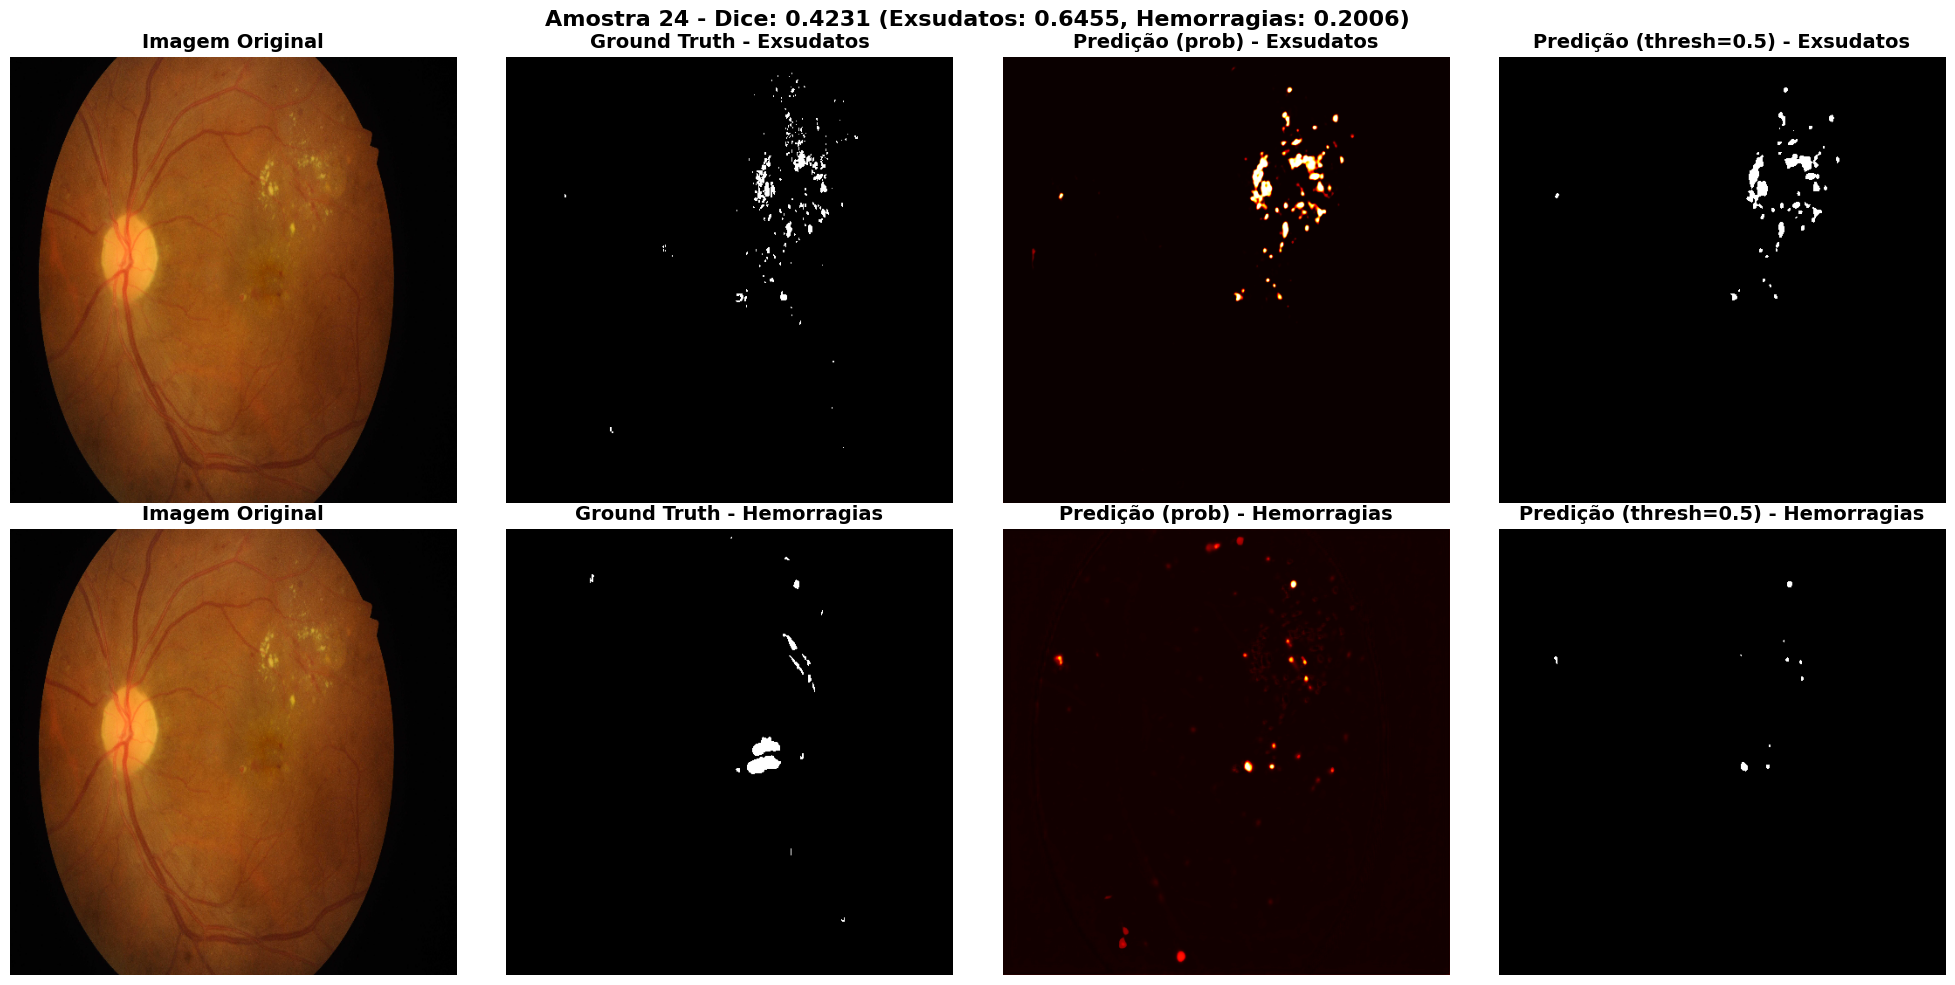

Dice Exsudatos: 0.6455
Dice Hemorragias: 0.2006
Dice Mean: 0.4231

Processando amostra 9/27


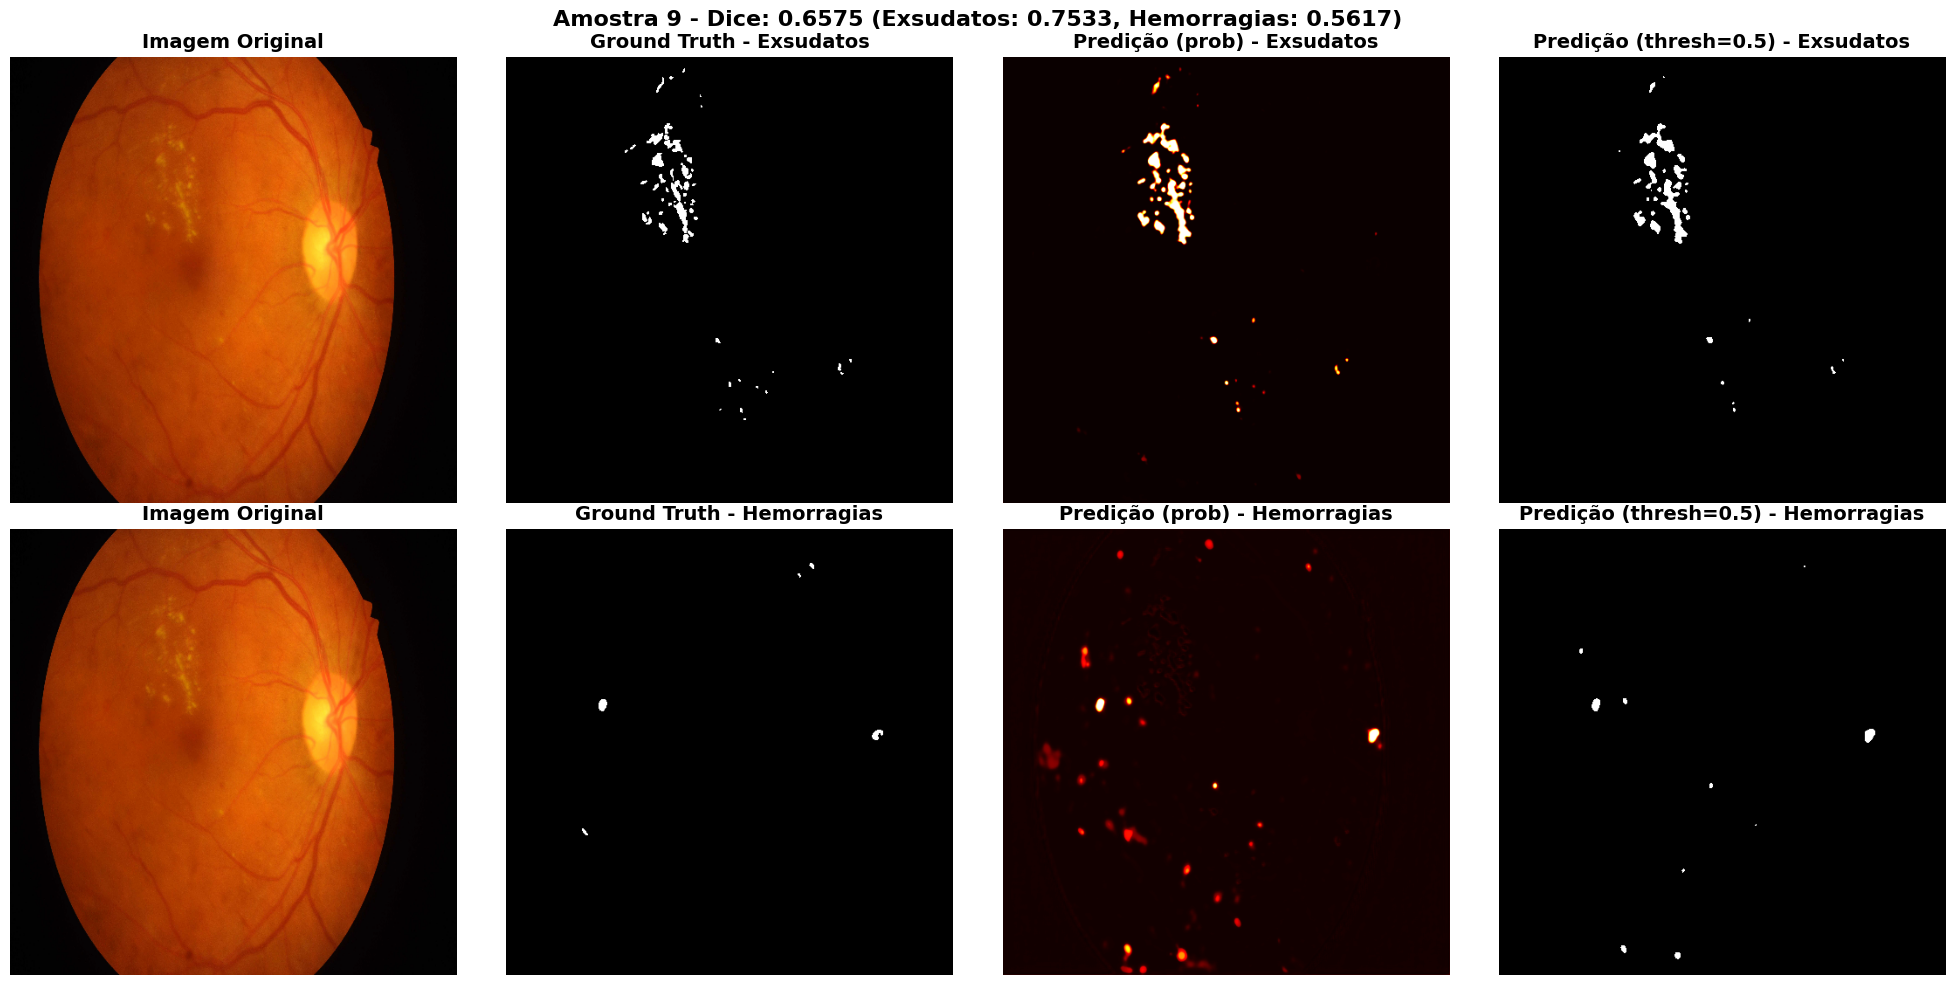

Dice Exsudatos: 0.7533
Dice Hemorragias: 0.5617
Dice Mean: 0.6575

Processando amostra 8/27


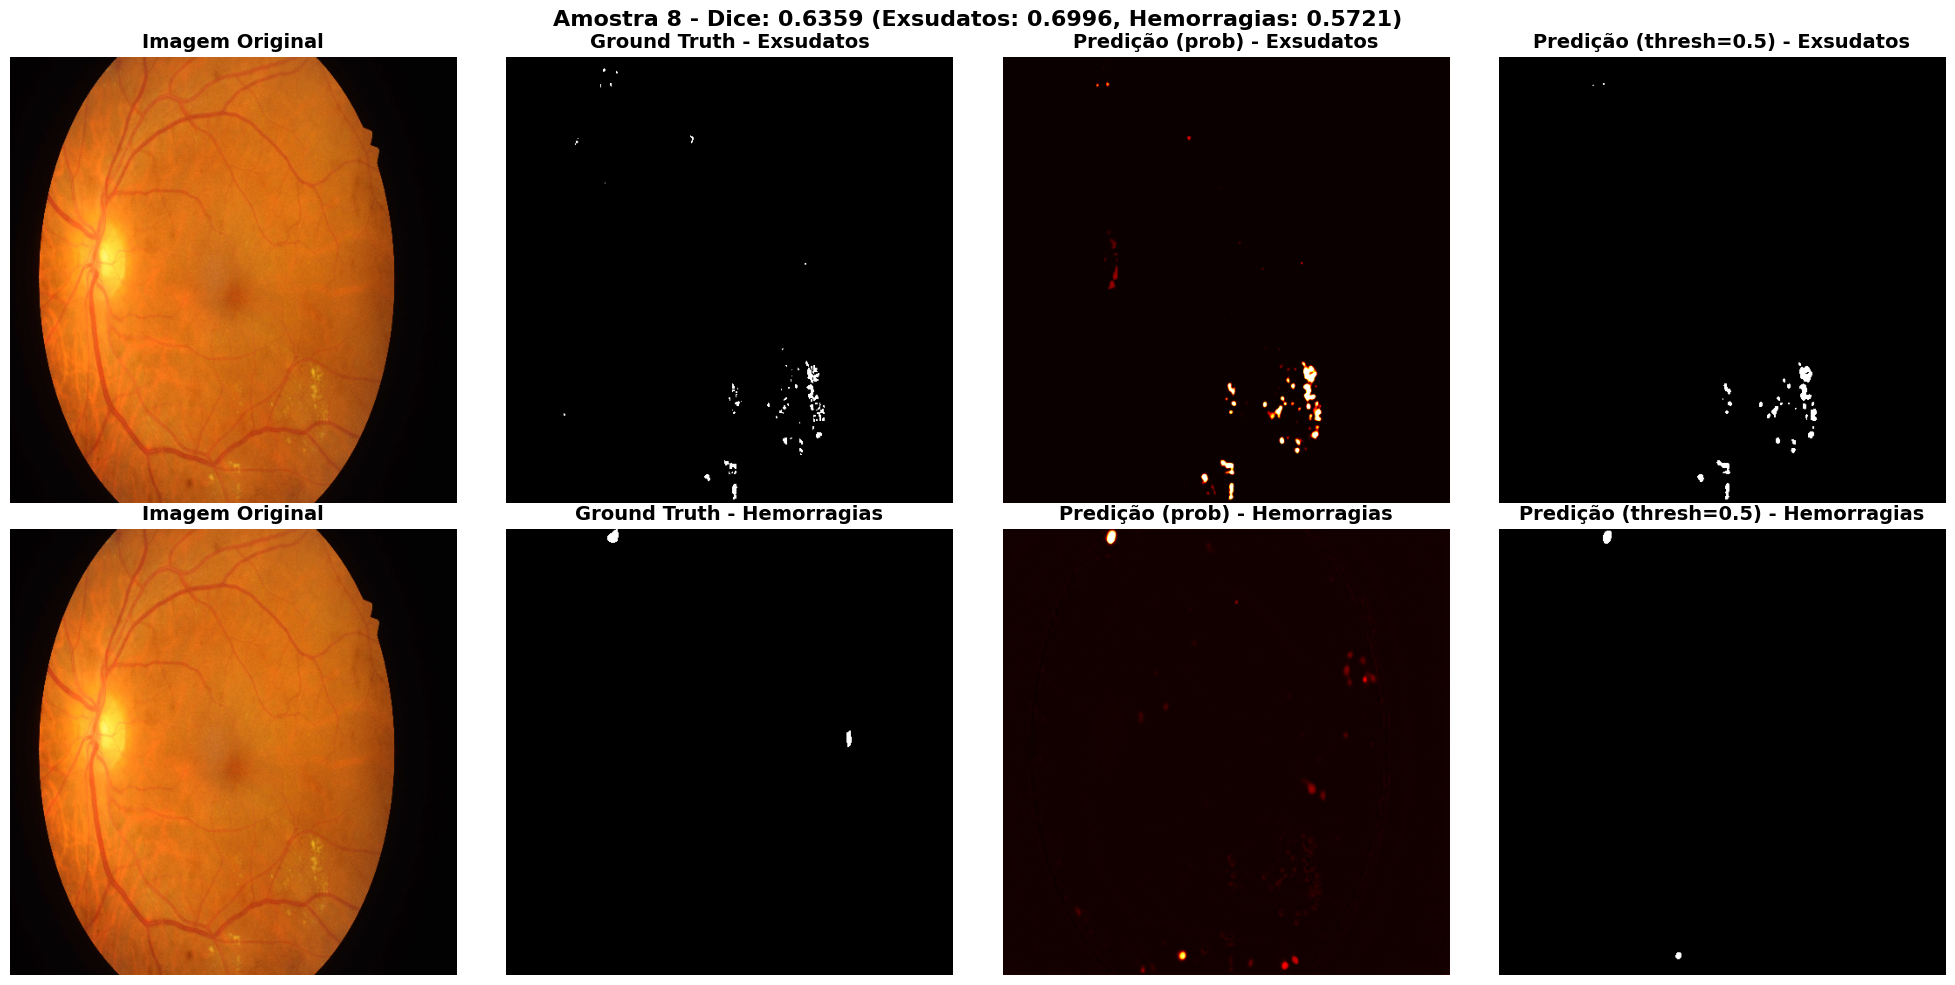

Dice Exsudatos: 0.6996
Dice Hemorragias: 0.5721
Dice Mean: 0.6359


In [16]:
# Visualizar cada amostra
results = []

for idx in sample_indices:
    print(f'\n{"="*80}')
    print(f'Processando amostra {idx+1}/{len(test_dataset)}')
    print(f'{"="*80}')
    
    dice_ex, dice_he, dice_mean = visualize_prediction(
        idx, 
        test_dataset, 
        models, 
        device,
        threshold=0.5
    )
    
    results.append({
        'idx': idx,
        'dice_exudatos': dice_ex,
        'dice_hemorragias': dice_he,
        'dice_mean': dice_mean
    })
    
    print(f'Dice Exsudatos: {dice_ex:.4f}')
    print(f'Dice Hemorragias: {dice_he:.4f}')
    print(f'Dice Mean: {dice_mean:.4f}')

## 5. Resumo das Predições

In [ ]:
import pandas as pd

# Criar DataFrame com resultados
df_results = pd.DataFrame(results)

print('\n' + '='*80)
print('RESUMO DAS AMOSTRAS VISUALIZADAS')
print('='*80)
print(df_results.to_string(index=False))

print('\n' + '='*80)
print('ESTATÍSTICAS')
print('='*80)
print(f"Dice Exsudatos    - Média: {df_results['dice_exudatos'].mean():.4f}, Std: {df_results['dice_exudatos'].std():.4f}")
print(f"Dice Hemorragias  - Média: {df_results['dice_hemorragias'].mean():.4f}, Std: {df_results['dice_hemorragias'].std():.4f}")
print(f"Dice Mean         - Média: {df_results['dice_mean'].mean():.4f}, Std: {df_results['dice_mean'].std():.4f}")
print('='*80)

## 6. Análise: Melhor e Pior Caso

In [ ]:
# Encontrar todas as amostras e calcular Dice
print('Calculando Dice para todas as amostras do test set...')

all_results = []

for idx in range(len(test_dataset)):
    sample = test_dataset[idx]
    image_tensor = sample['image'].unsqueeze(0)
    gt_mask = sample['mask'].numpy()
    
    pred_mask = predict_ensemble(image_tensor, models, device)
    pred_binary = (pred_mask > 0.5).astype(np.uint8)
    
    def dice_score(pred, gt):
        intersection = (pred * gt).sum()
        return (2. * intersection) / (pred.sum() + gt.sum() + 1e-8)
    
    dice_ex = dice_score(pred_binary[0], gt_mask[0])
    dice_he = dice_score(pred_binary[1], gt_mask[1])
    dice_mean = (dice_ex + dice_he) / 2
    
    all_results.append({
        'idx': idx,
        'dice_exudatos': dice_ex,
        'dice_hemorragias': dice_he,
        'dice_mean': dice_mean
    })

df_all = pd.DataFrame(all_results)

# Melhor e pior
best_idx = df_all['dice_mean'].idxmax()
worst_idx = df_all['dice_mean'].idxmin()

print(f'\nMelhor caso: Amostra {best_idx+1} - Dice = {df_all.loc[best_idx, "dice_mean"]:.4f}')
print(f'Pior caso:   Amostra {worst_idx+1} - Dice = {df_all.loc[worst_idx, "dice_mean"]:.4f}')

In [ ]:
# Visualizar melhor caso
print('\n' + '='*80)
print('MELHOR CASO')
print('='*80)

visualize_prediction(best_idx, test_dataset, models, device, threshold=0.5)

In [ ]:
# Visualizar pior caso
print('\n' + '='*80)
print('PIOR CASO')
print('='*80)

visualize_prediction(worst_idx, test_dataset, models, device, threshold=0.5)

## 7. Distribuição de Performance

In [ ]:
# Histograma de Dice scores
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(df_all['dice_exudatos'], bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(df_all['dice_exudatos'].mean(), color='red', linestyle='--', linewidth=2, label=f'Média: {df_all["dice_exudatos"].mean():.4f}')
axes[0].set_xlabel('Dice Score', fontsize=12)
axes[0].set_ylabel('Frequência', fontsize=12)
axes[0].set_title('Distribuição - Exsudatos', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(df_all['dice_hemorragias'], bins=20, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(df_all['dice_hemorragias'].mean(), color='red', linestyle='--', linewidth=2, label=f'Média: {df_all["dice_hemorragias"].mean():.4f}')
axes[1].set_xlabel('Dice Score', fontsize=12)
axes[1].set_ylabel('Frequência', fontsize=12)
axes[1].set_title('Distribuição - Hemorragias', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].hist(df_all['dice_mean'], bins=20, edgecolor='black', alpha=0.7, color='green')
axes[2].axvline(df_all['dice_mean'].mean(), color='red', linestyle='--', linewidth=2, label=f'Média: {df_all["dice_mean"].mean():.4f}')
axes[2].set_xlabel('Dice Score', fontsize=12)
axes[2].set_ylabel('Frequência', fontsize=12)
axes[2].set_title('Distribuição - Média (Ambas Classes)', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'\nEstatísticas gerais (test set completo):' )
print(f'  Exsudatos:    {df_all["dice_exudatos"].mean():.4f} ± {df_all["dice_exudatos"].std():.4f}')
print(f'  Hemorragias:  {df_all["dice_hemorragias"].mean():.4f} ± {df_all["dice_hemorragias"].std():.4f}')
print(f'  Média:        {df_all["dice_mean"].mean():.4f} ± {df_all["dice_mean"].std():.4f}')

## 8. Comparação com Baseline

**Performance do modelo Wavelet Skip 1:**
- Test Dice: **0.6721**
- Exsudatos: **0.7275**
- Hemorragias: **0.6167**

**Baseline (sem CLAHE):**
- Test Dice: 0.6501
- Exsudatos: 0.6984
- Hemorragias: 0.6017

**Ganhos:**
- Dice geral: +0.0220 (+3.4%)
- Exsudatos: +0.0291 (+4.2%)
- Hemorragias: +0.0150 (+2.5%)

✅ **O wavelet DWT no primeiro skip melhorou a detecção de ambas as classes!**